In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [10]:
# Set seeds to make the experiment more reproducible.
import random
def seed_everything(seed = 0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
seed = 0
seed_everything(seed)

In [11]:
# Define some parameters for the data loader:
BATCH_SIZE = 32
IMG_SIZE = 224

In [12]:
# Path of the dataset
input_path = '../input/paddy-disease-classification/'
train_data_dir = input_path + 'train_images/'
test_data_dir = input_path + 'test_images/'

In [13]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    validation_split = 0.2,
    subset="training",
    seed = 123,
    image_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE)

Found 10407 files belonging to 10 classes.
Using 8326 files for training.


In [14]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    validation_split = 0.2,
    subset="validation",
    seed = 123,
    image_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE)

Found 10407 files belonging to 10 classes.
Using 2081 files for validation.


In [15]:
# We can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
n_classes = len(class_names)
print(class_names)

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']


Show the first nine images and labels from the training set:

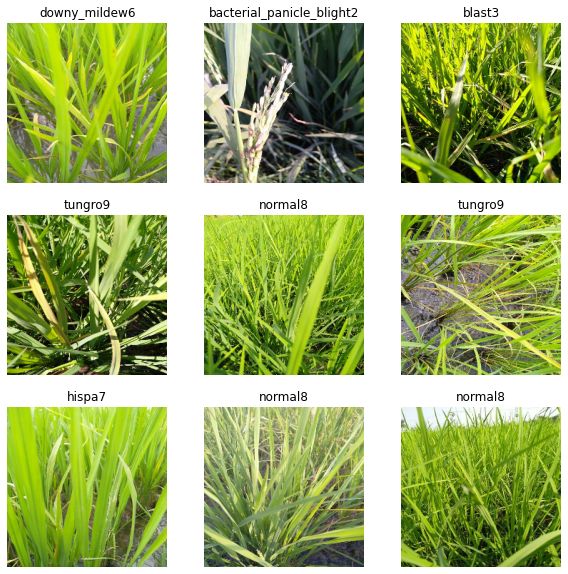

In [18]:
plt.figure(figsize = (10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]]+str(labels.numpy()[i]))
        plt.axis('off')

In [20]:
data_augmentation = keras.Sequential([
    layers.RandomRotation(factor = 0.1),
    layers.RandomFlip('horizontal'),
    layers.RandomTranslation(height_factor = 0.1, width_factor = 0.1),
    layers.RandomContrast(factor = 0.1),
])

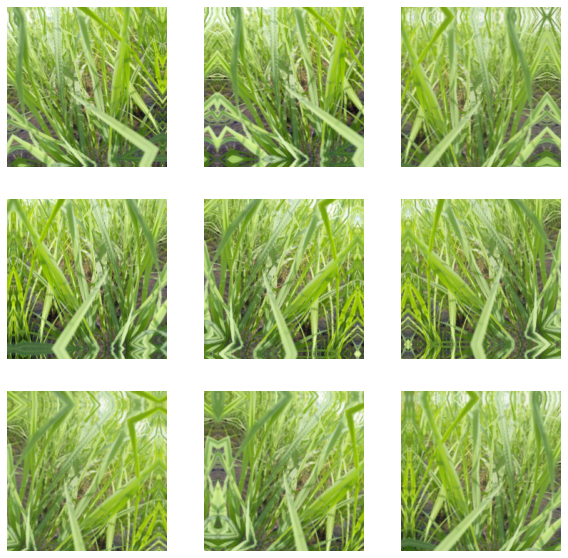

In [23]:
for image, labels in train_ds.take(1):
    plt.figure(figsize = (10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
#         plt.title(class_names[labels[i]])
        plt.axis('off')

In [24]:
AUTOTUNE = tf.data.AUTOTUNE
def prepare_dataset(ds):
    def input_preprocess(image, label):
        label = tf.one_hot(label, n_classes)
        return image, label
    ds = ds.map(input_preprocess, num_parallel_calls = AUTOTUNE)
    ds = ds.cache().prefetch(buffer_size = AUTOTUNE)
    return ds

In [25]:
train_ds = prepare_dataset(train_ds)
val_ds = prepare_dataset(val_ds)

In [26]:
def create_model(n_classes):
    
    inputs = layers.Input(shape = (IMG_SIZE, IMG_SIZE, 3))
    x = data_augmentation(inputs)
    conv_base = tf.keras.applications.EfficientNetB0(include_top = False, input_tensor = x, weights = 'imagenet')

    # Freeze the pretrained weights
    conv_base.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name = 'gap')(conv_base.output)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(1024, activation = 'relu')(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Dense(512, activation = 'relu')(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Dense(128, activation = 'relu')(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Dense(64, activation = 'relu')(x)
    x = layers.Dropout(0.25)(x)
    
    outputs = layers.Dense(n_classes, activation = 'softmax', name = 'pred')(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name = 'EfficientNetB0')
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3), 
        loss = 'categorical_crossentropy', 
        metrics = ['accuracy'])
    
    return model

model = create_model(n_classes)



16719872/16705208 [==============================] - 0s 0us/step


In [27]:
%%time
initial_epochs = 50
history = model.fit(train_ds,
                    epochs = initial_epochs,
                    validation_data = val_ds,
                    verbose = 2)

Epoch 1/50


2022-09-12 12:39:38.295439: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


261/261 - 81s - loss: 1.8827 - accuracy: 0.3530 - val_loss: 1.6218 - val_accuracy: 0.4580
Epoch 2/50
261/261 - 14s - loss: 1.5282 - accuracy: 0.4721 - val_loss: 1.2581 - val_accuracy: 0.5810
Epoch 3/50
261/261 - 14s - loss: 1.3301 - accuracy: 0.5578 - val_loss: 1.0854 - val_accuracy: 0.6343
Epoch 4/50
261/261 - 14s - loss: 1.2260 - accuracy: 0.5940 - val_loss: 0.9924 - val_accuracy: 0.6684
Epoch 5/50
261/261 - 14s - loss: 1.1338 - accuracy: 0.6314 - val_loss: 0.9140 - val_accuracy: 0.7049
Epoch 6/50
261/261 - 14s - loss: 1.0516 - accuracy: 0.6572 - val_loss: 0.9459 - val_accuracy: 0.6761
Epoch 7/50
261/261 - 14s - loss: 1.0013 - accuracy: 0.6769 - val_loss: 0.9096 - val_accuracy: 0.7107
Epoch 8/50
261/261 - 14s - loss: 0.9455 - accuracy: 0.6985 - val_loss: 0.8772 - val_accuracy: 0.7160
Epoch 9/50
261/261 - 14s - loss: 0.9093 - accuracy: 0.7133 - val_loss: 0.8228 - val_accuracy: 0.7333
Epoch 10/50
261/261 - 14s - loss: 0.8754 - accuracy: 0.7247 - val_loss: 0.7554 - val_accuracy: 0.7689


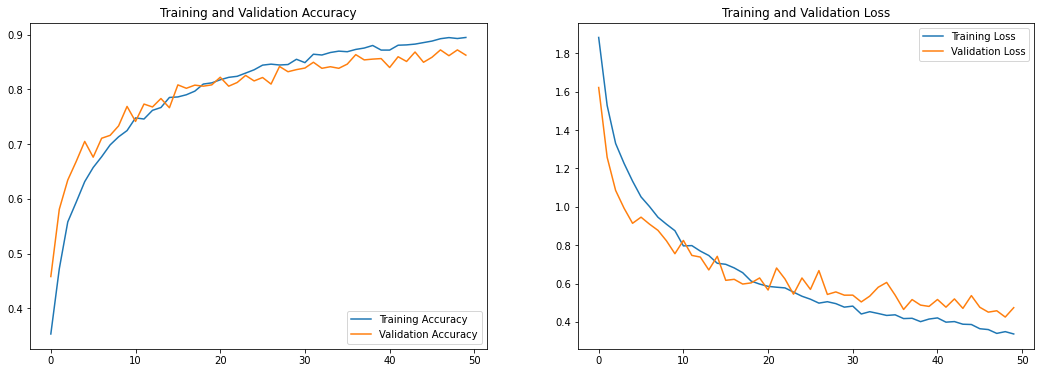

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize = (18, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.savefig("EfficientNetB0.png")
plt.show()

In [29]:
def unfreeze_model(model):
    # Fine-tune from this layer while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5),
        loss = 'categorical_crossentropy', 
        metrics = ['accuracy'])

unfreeze_model(model)

In [30]:
%%time
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs
history_fine = model.fit(train_ds,
                         epochs = total_epochs,
                         initial_epoch = history.epoch[-1],
                         validation_data = val_ds,
                         verbose = 1)

Epoch 50/70
261/261 [==============================] - 23s 64ms/step - loss: 0.3173 - accuracy: 0.9046 - val_loss: 0.4381 - val_accuracy: 0.8755
Epoch 51/70
261/261 [==============================] - 15s 57ms/step - loss: 0.2842 - accuracy: 0.9136 - val_loss: 0.4338 - val_accuracy: 0.8784
Epoch 52/70
261/261 [==============================] - 15s 58ms/step - loss: 0.2744 - accuracy: 0.9154 - val_loss: 0.4288 - val_accuracy: 0.8847
Epoch 53/70
261/261 [==============================] - 15s 57ms/step - loss: 0.2529 - accuracy: 0.9237 - val_loss: 0.4083 - val_accuracy: 0.8866
Epoch 54/70
261/261 [==============================] - 15s 57ms/step - loss: 0.2676 - accuracy: 0.9205 - val_loss: 0.4064 - val_accuracy: 0.8876
Epoch 55/70
261/261 [==============================] - 15s 58ms/step - loss: 0.2394 - accuracy: 0.9263 - val_loss: 0.4027 - val_accuracy: 0.8880
Epoch 56/70
261/261 [==============================] - 15s 57ms/step - loss: 0.2387 - accuracy: 0.9303 - val_loss: 0.4003 - val_ac

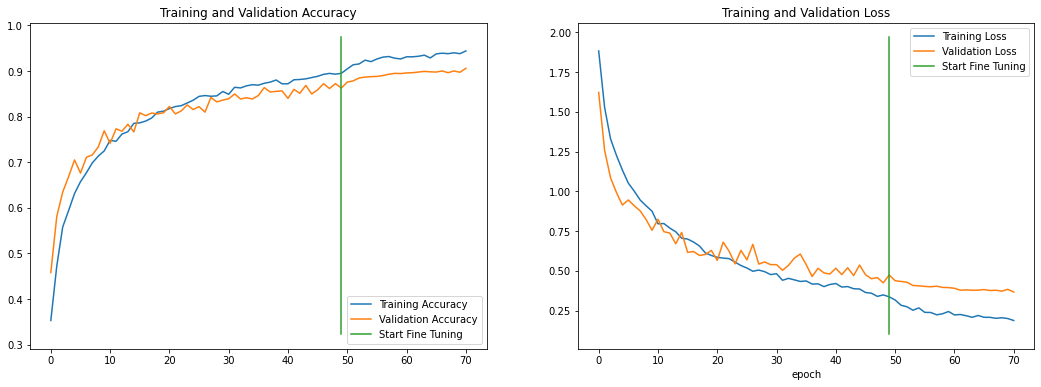

In [31]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize = (18, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label = 'Training Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
#plt.ylim([0.8, 1])
plt.plot([initial_epochs - 1, initial_epochs - 1],
          plt.ylim(), label = 'Start Fine Tuning')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
#plt.ylim([0, 1.0])
plt.plot([initial_epochs - 1, initial_epochs - 1],
         plt.ylim(), label = 'Start Fine Tuning')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig("EfficientNetB0_FineTune.png")
plt.show()

In [32]:
os.mkdir("Models")

In [33]:
model.save("Models/EfficientNetB0H5Model.h5")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [34]:
# !pip install tf-nightly-gpu
# import tensorflow as tf
# IMG_SHAPE = (224, 224, 3)
# model0 = tf.keras.applications.EfficientNetB0(input_shape=IMG_SHAPE, include_top=False, weights="imagenet")
# tf.keras.utils.plot_model(model0) # to draw and visualize
# model0.summary() 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 583.9/583.9 MB 1.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 42.0 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 27.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 39.6 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.4/439.4 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 63.5 MB/s eta 0:00:00:00:01
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
  Attempting uninstall: absl-py
    Found existing installation: absl-py 0.15.0
    Uninstalling absl-py-0.15.0:
      Successfully uninstalled absl-py-0.15.0
ERROR: pip's dependency resolver does not currently take into accoun

In [48]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    label_mode = None,
    seed = 123,
    image_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    shuffle = False)

AUTOTUNE = tf.data.AUTOTUNE
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

Found 3469 files belonging to 1 classes.


(224, 224, 3)
[[0.03432724 0.00648996 0.01942914 0.56187105 0.11743622 0.02459367
  0.07020087 0.10448793 0.02987555 0.03128831]]


2022-09-12 11:51:50.252453: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


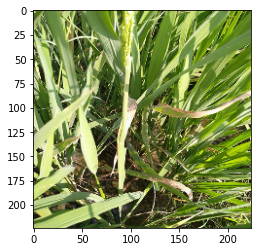

In [52]:
for img_batch in test_ds.take(1):
    plt.imshow(img_batch[3].numpy().astype("uint8"))
    print(img_batch[3].shape)
    imgg = tf.expand_dims(img_batch[3],0)
    print(model.predict(imgg))
    break

In [35]:
# 